# What do I want?

Previously in `classifier_overview.ipynb` I tested out some basic classifiers to get a smaller sample set, while still keeping completeness high.  I tested two basic classifiers: a RandomForest classifier and a Logistic Regression classifier.

For my training data, I started by getting objects and labels from COSMOS. For input features, I then matched those COSMOS galaxies to their nearest HSC counterpart. I then used HSC i-band magnitude, along with HSC g-r, r-i, i-z, z-y colors.

Choosing some arbitrary thresholds, I got similar results for the Random Forest and the Logistic Regression classifiers. In this notebook I'll look at the full ROC curves for both classifiers, in hopes of better understanding my results.

# Code

In [1]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(context="poster", style="ticks", font_scale=1.4)

import numpy as np
import pandas as pd

In [2]:
COSMOS_filename = os.path.join(dwarfz.data_dir_default, "COSMOS_reference.sqlite")
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [3]:
HSC_filename = os.path.join(dwarfz.data_dir_default, "HSC_COSMOS_median_forced.sqlite3")
HSC = dwarfz.datasets.HSC(HSC_filename)

In [4]:
COSMOS.df.shape

(518331, 13)

In [5]:
HSC.df.shape

(928534, 20)

In [6]:
matches_filename = os.path.join(dwarfz.data_dir_default, "matches.sqlite3")
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [7]:
combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med

photometry_cols = [
    "gcmodel_flux","gcmodel_flux_err","gcmodel_flux_flags",
    "rcmodel_flux","rcmodel_flux_err","rcmodel_flux_flags",
    "icmodel_flux","icmodel_flux_err","icmodel_flux_flags",
    "zcmodel_flux","zcmodel_flux_err","zcmodel_flux_flags",
    "ycmodel_flux","ycmodel_flux_err","ycmodel_flux_flags",
]

for col in photometry_cols:
    combined[col] = HSC.df.loc[combined.catalog_2_ids][col].values

## Turn fluxes into rough colors
Yes, I know these aren't exactly the right colors since I'm not including zero-points, but that shouldn't affect the results.

(When I get a chance, I'll re-download the dataset so that it includes magnitudes not just fluxes)

In [8]:
combined["g_minus_r"] = -.4*np.log10(combined["gcmodel_flux"] / combined["rcmodel_flux"])
combined["r_minus_i"] = -.4*np.log10(combined["rcmodel_flux"] / combined["icmodel_flux"])
combined["i_minus_z"] = -.4*np.log10(combined["icmodel_flux"] / combined["zcmodel_flux"])
combined["z_minus_y"] = -.4*np.log10(combined["zcmodel_flux"] / combined["ycmodel_flux"])

/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/Users/egentry/anaconda3/li

For now, filter out bad photometry. Later I could consider passing this into the classifier, as an imputed/sentinel value

In [9]:
mask =    np.isfinite(combined["g_minus_r"]) & np.isfinite(combined["r_minus_i"]) \
        & np.isfinite(combined["i_minus_z"]) & np.isfinite(combined["z_minus_y"]) \
        & np.isfinite(combined["icmodel_flux"]) \
        & (~combined.gcmodel_flux_flags) & (~combined.rcmodel_flux_flags) \
        & (~combined.icmodel_flux_flags) & (~combined.zcmodel_flux_flags) \
        & (~combined.ycmodel_flux_flags)

combined = combined[mask]

combined["log_icmodel_flux"] = np.log10(combined["icmodel_flux"])

# Create classification labels

Class A: matched **and** (low redshift + low mass)

Class B: matched **but not** (low redshift + low mass)

In [10]:
low_z    = (combined.photo_z  < .15)
low_mass = (combined.log_mass < 9)

In [11]:
class_a = (low_z & low_mass)
class_b = ~(low_z & low_mass)

In [12]:
class_a.mean()

0.022124239582581931

In [13]:
combined["low_z_low_mass"] = class_a
combined.head()

,catalog_2_ids,sep,match,error,ra,dec,photo_z,log_mass,gcmodel_flux,gcmodel_flux_err,...,zcmodel_flux_flags,ycmodel_flux,ycmodel_flux_err,ycmodel_flux_flags,g_minus_r,r_minus_i,i_minus_z,z_minus_y,log_icmodel_flux,low_z_low_mass
catalog_1_ids,,,,,,,,,,,,,,,,,,,,,
219656,43158447025298860,0.471546,True,False,150.388349,1.614538,2.3343,8.99275,5.800470e-31,2.102453e-31,...,False,4.328439e-31,1.392682e-30,False,0.144670,0.098257,-0.030754,-0.263026,-29.629218,False
219741,43158447025298862,0.202378,True,False,150.402935,1.614631,2.1991,9.71373,8.775548e-31,2.110055e-31,...,False,2.347631e-30,1.432457e-30,False,0.099205,0.012165,-0.071279,0.130851,-29.778300,False
219743,43158584464246387,0.207967,True,False,150.295083,1.614662,2.4407,9.77811,1.312252e-30,3.044583e-31,...,False,3.960493e-30,2.091224e-30,False,0.119917,0.073225,0.032795,-0.034045,-29.399128,False
219744,43158584464253383,0.295316,True,False,150.239919,1.614675,0.2079,7.04224,8.597155e-31,1.999684e-31,...,False,6.612980e-31,1.594763e-30,False,0.087705,-0.006288,0.078045,-0.205045,-29.862103,False
219769,43158584464277538,0.410593,True,False,150.180826,1.614706,1.2060,7.92008,1.152067e-30,1.891072e-31,...,False,1.530384e-30,1.368668e-30,False,-0.166723,-0.537628,0.716014,0.037666,-31.699399,False


# Build Classifiers

In [14]:
features = combined.loc[:,["g_minus_r", "r_minus_i", "i_minus_z", "z_minus_y",
                              "log_icmodel_flux"]]

target = combined.loc[:,["low_z_low_mass"]]

In [15]:
target.mean()

low_z_low_mass    0.022124
dtype: float64

## Partition training and testing sets

In [16]:
testing_fraction = .1
test_set_indices = np.random.choice(target.index.values, 
                                    replace=False,
                                    size=int(testing_fraction*target.size)
                                   )

training_set_indices = np.array(list(set(target.index.values) - set(test_set_indices)))

features_train = features.loc[training_set_indices]
features_test  = features.loc[test_set_indices]

target_train   = target.loc[training_set_indices]
target_test    = target.loc[test_set_indices]

true_a =  target_test.values.flatten()
true_b = ~target_test.values.flatten()

In [17]:
def get_classification_characteristics(target_prob, threshold_prob, verbose=False):

    target_prediction = (target_prob > threshold_prob)
    
    prediction_a =  target_prediction
    prediction_b = ~target_prediction
    
    completeness = (true_a & prediction_a).sum() / (true_a).sum() 
    
    purity = (true_a & prediction_a).sum() / (prediction_a).sum() 
    
    sample_size_reduction = prediction_a.size / prediction_a.sum()
    
    true_positives  = np.sum(true_a & prediction_a)
    false_positives = np.sum(true_b & prediction_a)
    
    true_negatives  = np.sum(true_b & prediction_b)
    false_negatives = np.sum(true_a & prediction_b)
    
    true_positive_rate = true_positives / true_a.sum()
    false_positive_rate = false_positives / true_b.sum()
    
    if verbose:
        print("completeness:          ", completeness)
        print("purity:                ", purity)
        print("sample_size_reduction: ", sample_size_reduction)
        print("true  positive rate:   ", true_positive_rate)
        print("false positive rate:   ", false_positive_rate)
        
    return {
        "completeness": completeness,
        "purity": purity,
        "sample_size_reduction": sample_size_reduction,
        "threshold_prob": threshold_prob,
        "true_positive_rate": true_positive_rate,
        "false_positive_rate": false_positive_rate,
           }

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

classifier_RF = RandomForestClassifier()
classifier_RF = classifier_RF.fit(features_train, target_train.values.flatten())

target_prob_RF = classifier_RF.predict_proba(features_test)[:,1]
print("min prob: ", target_prob_RF.min())
print("max prob: ", target_prob_RF.max())


min prob:  0.0
max prob:  1.0


In [19]:
get_classification_characteristics(target_prob_RF, .01, verbose=True)

completeness:           0.46540027137
purity:                 0.0628896222956
sample_size_reduction:  6.10029336267
true  positive rate:    0.46540027137
false positive rate:    0.157097190631


{'completeness': 0.46540027137042062,
 'false_positive_rate': 0.15709719063133953,
 'purity': 0.062889622295562886,
 'sample_size_reduction': 6.1002933626695999,
 'threshold_prob': 0.01,
 'true_positive_rate': 0.46540027137042062}

In [20]:
threshold_probs = np.linspace(0, 1, num=100)[1:-1]
results_RF = [get_classification_characteristics(target_prob_RF, threshold_prob)
              for threshold_prob in threshold_probs]

In [21]:
completenesses_RF         = [result["completeness"] for result in results_RF]
purities_RF               = [result["purity"] for result in results_RF]
sample_size_reductions_RF = [result["sample_size_reduction"] for result in results_RF]
true_positive_rates_RF    = [result["true_positive_rate"] for result in results_RF]
false_positive_rates_RF   = [result["false_positive_rate"] for result in results_RF]

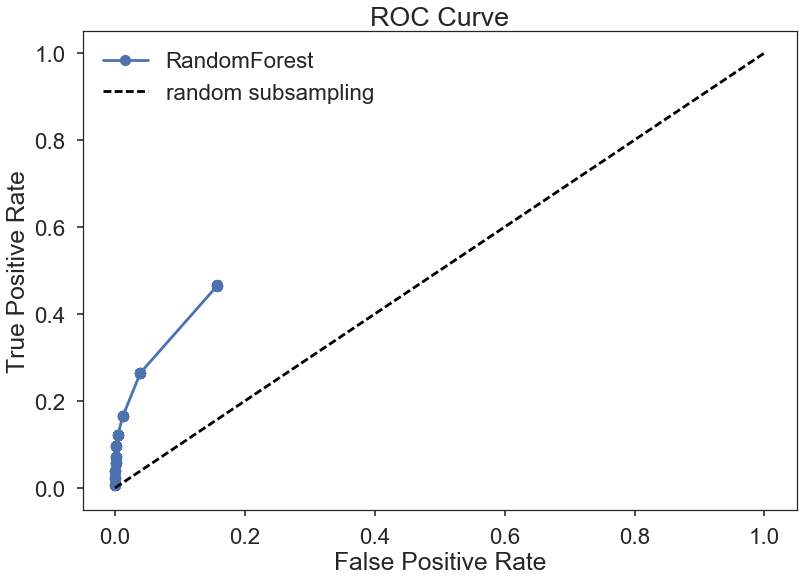

In [22]:
plt.plot(false_positive_rates_RF, true_positive_rates_RF, 
         marker="o", label="RandomForest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1], [0,1], 
         color="k", linestyle="dashed", label="random subsampling"
        )

plt.legend(loc="best")
plt.title("ROC Curve")

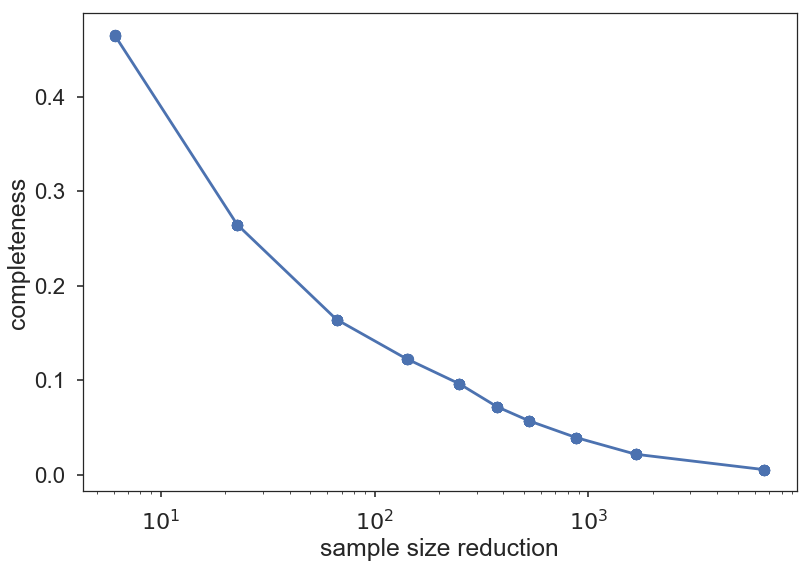

In [23]:
plt.plot(sample_size_reductions_RF, completenesses_RF, marker="o")
plt.xlabel("sample size reduction")
plt.ylabel("completeness")
plt.xscale("log")

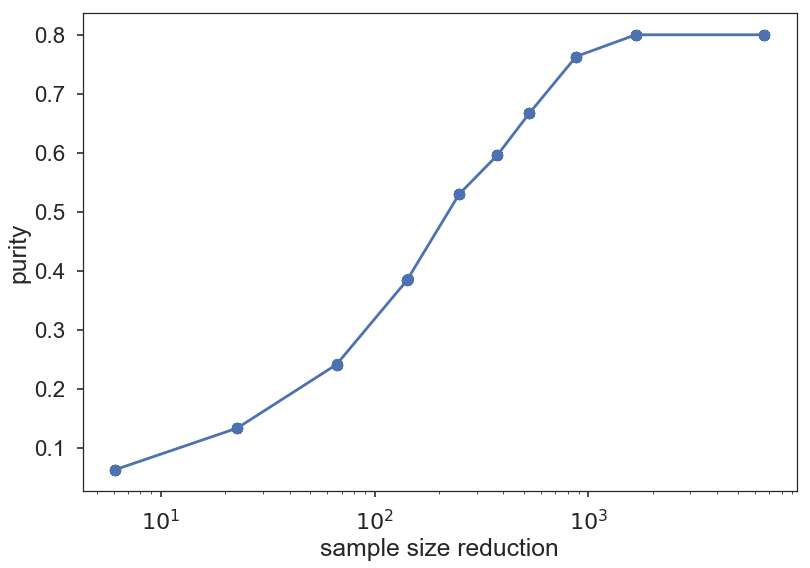

In [24]:
plt.plot(sample_size_reductions_RF, purities_RF, marker="o")
plt.xlabel("sample size reduction")
plt.ylabel("purity")
plt.xscale("log")

## Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(class_weight="balanced")
classifier_LR = classifier_LR.fit(features_train, np.array(target_train.values.flatten(), dtype=int))

target_prob_LR = classifier_LR.predict_proba(features_test)[:,1]
print("min prob: ", target_prob_LR.min())
print("max prob: ", target_prob_LR.max())

min prob:  0.000183864450446
max prob:  0.997115869277


In [26]:
get_classification_characteristics(target_prob_LR, .01, verbose=True)

completeness:           0.998643147897
purity:                 0.0221439961489
sample_size_reduction:  1.00102295634
true  positive rate:    0.998643147897
false positive rate:    0.998985676523


{'completeness': 0.99864314789687925,
 'false_positive_rate': 0.99898567652302206,
 'purity': 0.022143996148870235,
 'sample_size_reduction': 1.0010229563438338,
 'threshold_prob': 0.01,
 'true_positive_rate': 0.99864314789687925}

In [27]:
threshold_probs = np.linspace(0, 1)[1:-1]
results_LR = [get_classification_characteristics(target_prob_LR, threshold_prob)
              for threshold_prob in threshold_probs]

In [28]:
completenesses_LR         = [result["completeness"] for result in results_LR]
purities_LR               = [result["purity"] for result in results_LR]
sample_size_reductions_LR = [result["sample_size_reduction"] for result in results_LR]
true_positive_rates_LR    = [result["true_positive_rate"] for result in results_LR]
false_positive_rates_LR   = [result["false_positive_rate"] for result in results_LR]

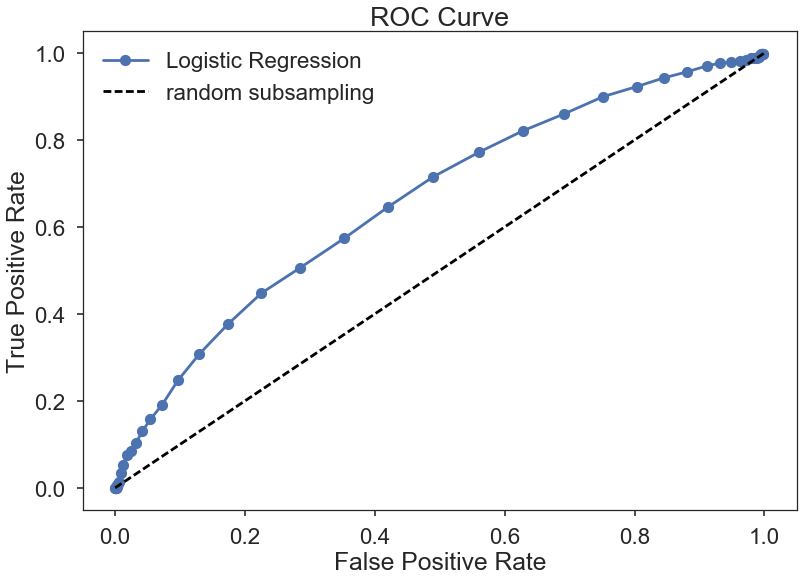

In [29]:
plt.plot(false_positive_rates_LR, true_positive_rates_LR, 
         marker="o", label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1], [0,1], 
         color="k", linestyle="dashed", label="random subsampling"
        )

plt.legend(loc="best")

plt.title("ROC Curve")

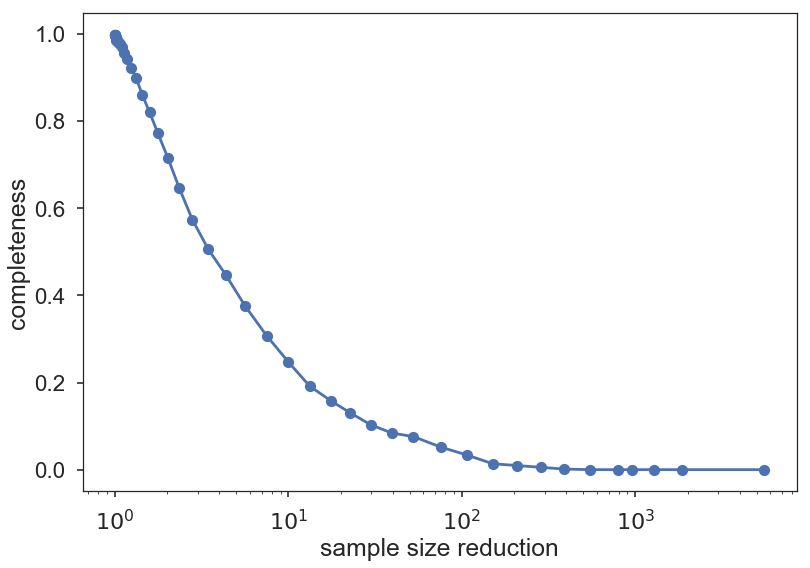

In [30]:
plt.plot(sample_size_reductions_LR, completenesses_LR, marker="o")
plt.xlabel("sample size reduction")
plt.ylabel("completeness")
plt.xscale("log")

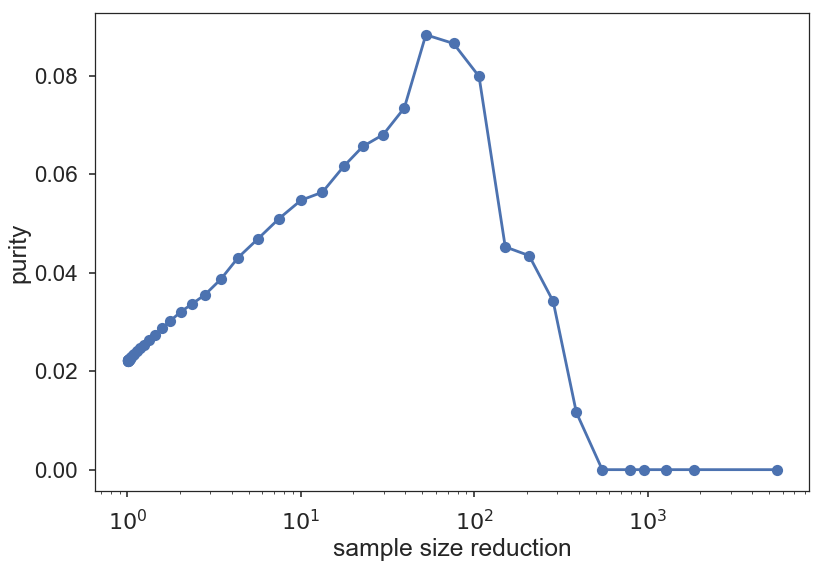

In [31]:
plt.plot(sample_size_reductions_LR, purities_LR, marker="o")
plt.xlabel("sample size reduction")
plt.ylabel("purity")
plt.xscale("log")

## Combined plots

In [32]:
color_LR = "b"
color_RF = "g"

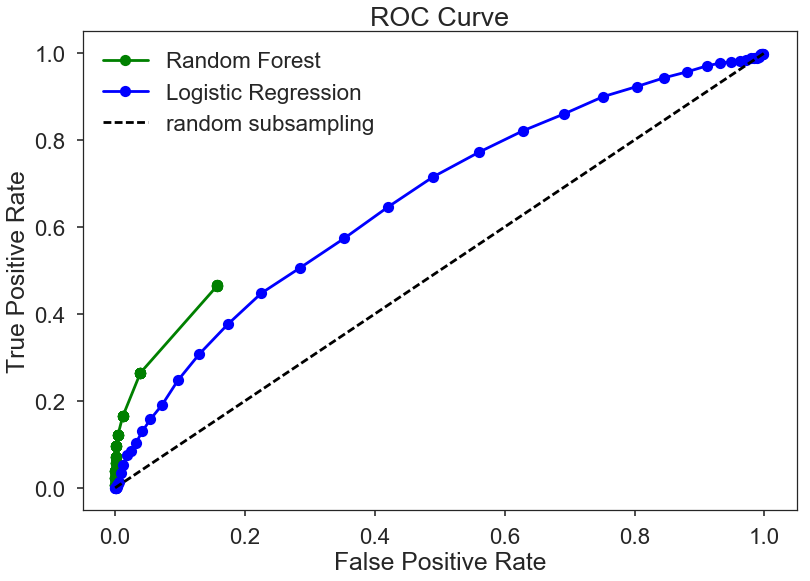

In [33]:
plt.plot(false_positive_rates_RF, true_positive_rates_RF, 
         marker="o", color=color_RF, label="Random Forest")

plt.plot(false_positive_rates_LR, true_positive_rates_LR, 
         marker="o", color=color_LR, label="Logistic Regression")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1], [0,1], 
         color="k", linestyle="dashed", label="random subsampling"
        )

plt.legend(loc="best")

plt.title("ROC Curve")

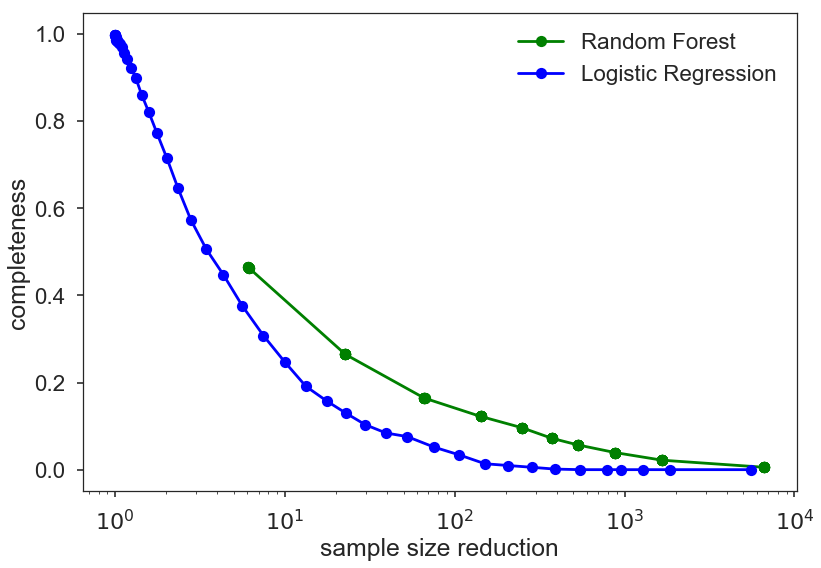

In [34]:
plt.plot(sample_size_reductions_RF, completenesses_RF, 
         marker="o", color=color_RF, label="Random Forest",
        )

plt.plot(sample_size_reductions_LR, completenesses_LR, 
         marker="o", color=color_LR, label="Logistic Regression",
        )
plt.xlabel("sample size reduction")
plt.ylabel("completeness")
plt.xscale("log")

plt.legend(loc="best")

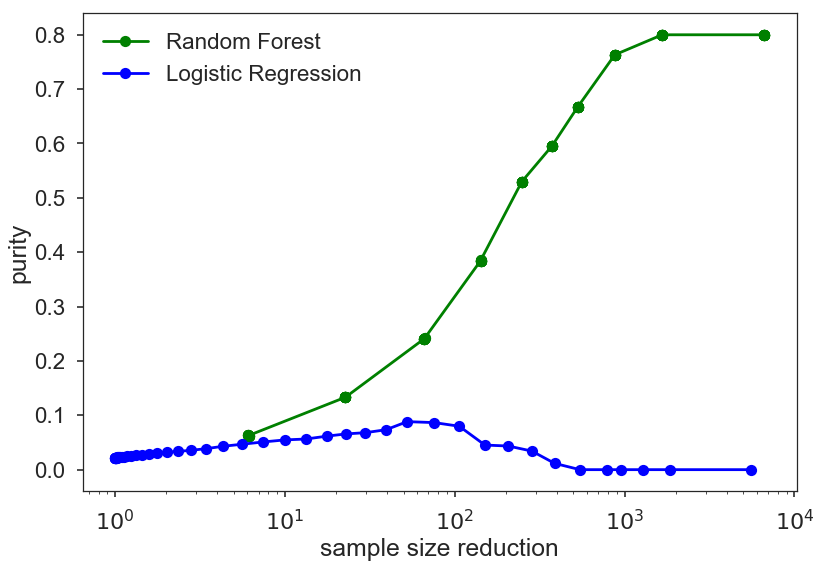

In [35]:
plt.plot(sample_size_reductions_RF, purities_RF, 
         marker="o", color=color_RF, label="Random Forest", 
        )
plt.plot(sample_size_reductions_LR, purities_LR, 
         marker="o", color=color_LR, label="Logistic Regression", 
        )

plt.xlabel("sample size reduction")
plt.ylabel("purity")
plt.xscale("log")

plt.legend(loc="best")

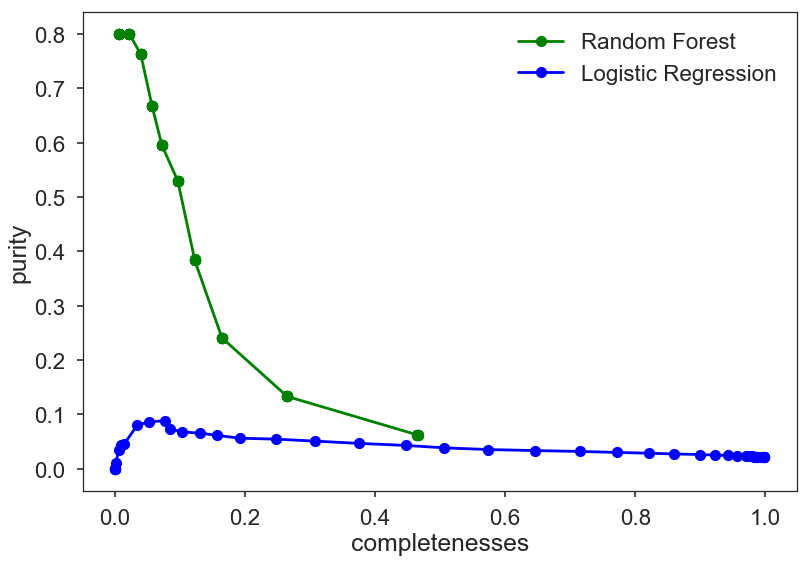

In [36]:
plt.plot(completenesses_RF, purities_RF, 
         marker="o", color=color_RF, label="Random Forest", 
        )
plt.plot(completenesses_LR, purities_LR, 
         marker="o", color=color_LR, label="Logistic Regression", 
        )

plt.xlabel("completenesses")
plt.ylabel("purity")

plt.legend(loc="best")

# Discussion

These results generally behave how I expect.  The key things to notice are: 

1) Random Forest is almost always better, above a sample size reduction of ~6

2) Logistic Regression allows you to reach higher completeness. (Random Forest reaches a probability floor, related to the finite size of the sample set.) 

3) The objects that logistic regression is most confident about (top ~1%) are actually _false positives_